# KNIT6
#### Measurement Framework Library
# MFLib API Examples: Prepare a Slice for KNIT6 Tutorial

Add the Measurement Node and Measurement Network while creating new slice.  
This notebook shows the process of creating a 3 node experiment with the needed Measurement Node and Measurement Network.  
The process of creating the sice is the same as creating any slice but after the topology has been set, MFLib needs to add the extra node and network before the slice is submitted. 

## Imports
This series of notebooks all need a common set of imports which are defined in [Common Imports](./KNIT6_common_imports.ipynb)

**slice_name** is defined in this step. If you would like to change the slice_name, edit [Common Imports](./KNIT6_common_imports.ipynb)

In [ ]:
%run "./KNIT6_common_imports.ipynb"

## Setup Experiment Slice

### Set Slice Information

In [ ]:
%%time

# Sites without PTP + NCSA where meas node is located
#[site1,site2,site3] = fablib.get_random_sites(count=3, avoid=["DALL","GPN","LBNL","RENC","SALT","TACC","UKY","WASH","NCSA","LOSA","GATECH","INDI","NEWY","SRI"])

# Sites without PTP + NCSA where meas node is located + Problem sites
[site1,site2,site3] = fablib.get_random_sites(count=3, avoid=["DALL","GPN","LBNL","RENC","SALT","TACC","UKY","WASH","NCSA","LOSA","GATECH","INDI","MAX", "MASS","NEWY","SRI","UCSD"])


node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'

network1_name='net1'
network2_name='net2'
network3_name='net3'

node1_nic_name = 'nic1'
node2_nic_name = 'nic2'
node3_nic_name = 'nic3'

print(f"Setting up slice {slice_name}")
print(f"Using sites {site1}, {site2}, {site3}")

### Create Experiment Topology

In [ ]:
try:
    #Create Slice
    slice = fablib.new_slice(name=slice_name)
    
    # Node1
    node1 = slice.add_node(name=node1_name, site=site1, image='docker_rocky_8')
    iface1 = node1.add_component(model='NIC_Basic', name=node1_nic_name).get_interfaces()[0]
    
    # Node2
    node2 = slice.add_node(name=node2_name, site=site2, image='docker_rocky_8')
    iface2  = node2.add_component(model='NIC_Basic', name=node2_nic_name).get_interfaces()[0]

    # Node3
    node3 = slice.add_node(name=node3_name, site=site3, image='docker_rocky_8')
    iface3  = node3.add_component(model='NIC_Basic', name=node3_nic_name).get_interfaces()[0]

    # Networks
    net1 = slice.add_l3network(name=network1_name, interfaces=[iface1], type='IPv4')
    net2 = slice.add_l3network(name=network2_name, interfaces=[iface2], type='IPv4')
    net3 = slice.add_l3network(name=network3_name, interfaces=[iface3], type='IPv4')

    print(f"Slice Topology Done.")
except Exception as e:
    print(f"Exception: {e}")

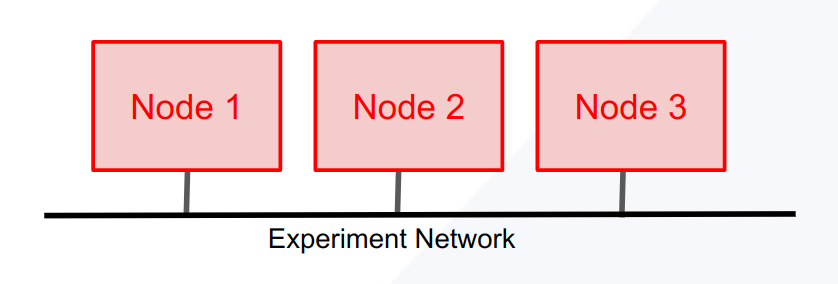

### Add measurement node to slice topology.
To add the Measurement Node and Measurement Network use the static method mflib.addMeasNode(slice), where slice is the fablib slice object.

In [ ]:
# Add measurement node to topology using static method.
MFLib.addMeasNode(slice, disk=100, image='docker_ubuntu_20')
print("Done")

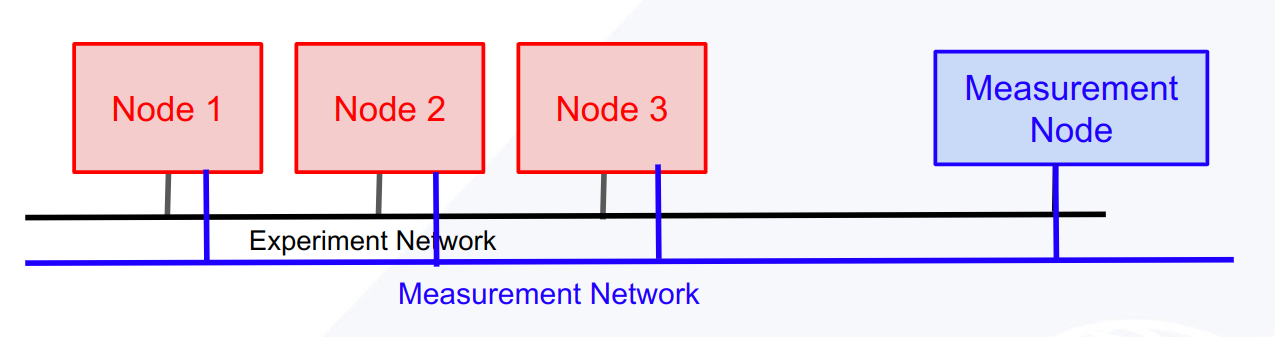

### Submit the Slice

In [ ]:
%%time
try:
    # Submit Slice Request
    print(f'Submitting the new slice, "{slice_name}"...')
    slice.submit(wait_interval=60)
    print(f'{slice_name} creation done.')

except Exception as e:
    print(f"Slice Fail: {e}")
    traceback.print_exc()

# Check on Slice
If the slice timed out or you have to restart this notebook run the following to get the slice information.

In [ ]:
#slice = fablib.get_slice(slice_name)
#slice.wait_jupyter(interval=60)

# Slice StableOK
The slice has now been created with the Measurement Node and the Measurement Network. 

## Configure IP Addresses

Some experiments use FABRIC layer 2 networks to enable deploying non-IP layer 3 networks.  If this describes your experiment, your nodes and network are ready. You can now login to the nodes and deploy your experiment.

Most users will want to configure IP addresses on their new nodes.  FABlib provides some useful methods to help you configure basic IP addresses. 

### Get the Assigned Subnet

FABnetv4 networks are assigned a subnet and gateway by FABRIC.  You can get the subnet and available IPs from the FABlib objects. 

In [ ]:
try:
    network1 = slice.get_network(name=network1_name)
    network1_available_ips = network1.get_available_ips()
    network1.show()
    
    network2 = slice.get_network(name=network2_name)
    network2_available_ips =  network2.get_available_ips()
    network2.show()
    
    network3 = slice.get_network(name=network3_name)
    network3_available_ips =  network3.get_available_ips()
    network3.show()
    
    
except Exception as e:
    print(f"Exception: {e}")

### Configure Node1

Get the node and the interface you wish to configure.  You can use `node.get_interface` to get the interface that is connected to the specified network.  Then `pop` an IP address from the list of available IPs and call `iface.ip_addr_add` to set the IP and subnet.  

Then set a route from *this network* to the *other network* through the specified gateway.


Optionally, use the `node.execute()` method to show the results of adding the IP address and route.


In [ ]:
try:
    node1 = slice.get_node(name=node1_name)        
    node1_iface = node1.get_interface(network_name=network1_name)  
    node1_addr = network1_available_ips.pop(0)
    node1_iface.ip_addr_add(addr=node1_addr, subnet=network1.get_subnet())
    
    node1.ip_route_add(subnet=network2.get_subnet(), gateway=network1.get_gateway())
    node1.ip_route_add(subnet=network3.get_subnet(), gateway=network1.get_gateway())
    
    stdout, stderr = node1.execute(f'ip addr show {node1_iface.get_os_interface()}')
    stdout, stderr = node1.execute(f'ip route list')

except Exception as e:
    print(f"Exception: {e}")

### Configure Node2

Repeat the steps to add the next available IP to the second node and a route to the first network.

In [ ]:
try:
    node2 = slice.get_node(name=node2_name)        
    node2_iface = node2.get_interface(network_name=network2_name) 
    node2_addr = network2_available_ips.pop(0)
    node2_iface.ip_addr_add(addr=node2_addr, subnet=network2.get_subnet())
    
    node2.ip_route_add(subnet=network1.get_subnet(), gateway=network2.get_gateway())
    node2.ip_route_add(subnet=network3.get_subnet(), gateway=network2.get_gateway())
    
    stdout, stderr = node2.execute(f'ip addr show {node2_iface.get_os_interface()}')    
    stdout, stderr = node2.execute(f'ip route list')

except Exception as e:
    print(f"Exception: {e}")

### Configure Node3
Repeat the steps to add the next available IP to the third node and a route to the first network.

In [ ]:
try:
    node3 = slice.get_node(name=node3_name)        
    node3_iface = node3.get_interface(network_name=network3_name) 
    node3_addr = network3_available_ips.pop(0)
    node3_iface.ip_addr_add(addr=node3_addr, subnet=network3.get_subnet())
    
    node3.ip_route_add(subnet=network1.get_subnet(), gateway=network3.get_gateway())
    node3.ip_route_add(subnet=network2.get_subnet(), gateway=network3.get_gateway())
    
    stdout, stderr = node3.execute(f'ip addr show {node3_iface.get_os_interface()}')    
    stdout, stderr = node3.execute(f'ip route list')

except Exception as e:
    print(f"Exception: {e}")

-----
# Slice Setup Is Complete  
The slice has now been created with the Measurement Node and the Measurement Network. The next step is to install the Measurement Framework for use. See [Instrumentize a Slice](./KNIT6_instrumentize_a_slice.ipynb)  
You may also use the below methods to get general slice information or extend the slice. 

-----